## Model partition calibration example

In [1]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn

from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents, partition_skycomponent_neighbours

from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from processing_library.image.operations import copy_image, create_empty_image_like
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.skycomponent.operations import filter_skycomponents_by_flux
from wrappers.serial.simulation.mpc import create_gaintable_from_screen, sum_visibility_over_partitions, \
    calculate_sf_from_screen
from wrappers.serial.skymodel.operations import show_skymodel

from processing_components.simulation.mpc import expand_skymodel_by_skycomponents

from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits

from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.arlexecute.skycomponent.operations import insert_skycomponent
from wrappers.arlexecute.image.operations import smooth_image, show_components

from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow
from workflows.serial.imaging.imaging_serial import weight_list_serial_workflow, taper_list_serial_workflow
from workflows.serial.pipelines.pipeline_serial import continuum_imaging_list_serial_workflow, \
    ical_list_serial_workflow
from data_models.data_model_helpers import import_skycomponent_from_hdf5, import_gaintable_from_hdf5

from data_models.data_model_helpers import import_skymodel_from_hdf5
from workflows.arlexecute.imaging.imaging_arlexecute import invert_list_arlexecute_workflow
from workflows.arlexecute.skymodel.skymodel_arlexecute import predict_skymodel_list_arlexecute_workflow
from workflows.arlexecute.skymodel.skymodel_arlexecute import extract_datamodels_skymodel_list_arlexecute_workflow
from workflows.arlexecute.skymodel.skymodel_arlexecute import invert_skymodel_list_arlexecute_workflow
from workflows.arlexecute.skymodel.skymodel_arlexecute import convolve_skymodel_list_arlexecute_workflow
from wrappers.arlexecute.skymodel.operations import calculate_skymodel_equivalent_image, \
    update_skymodel_from_image, update_skymodel_from_gaintables
from workflows.arlexecute.imaging.imaging_arlexecute import deconvolve_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import deconvolve_list_serial_workflow
from data_models.data_model_helpers import export_skymodel_to_hdf5
from workflows.arlexecute.calibration.calibration_arlexecute import calibrate_list_arlexecute_workflow

from data_models.data_model_helpers import import_blockvisibility_from_hdf5

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client

In [2]:
import logging
def init_logging():
    logging.basicConfig(filename='results/low-sims-mpc.log',
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [4]:
n_workers=8
c = get_dask_Client(memory_limit=256 * 1024 * 1024 * 1024 // n_workers, n_workers=n_workers)
arlexecute.set_client(client=c)
arlexecute.run(init_logging)

Creating LocalCluster and Dask Client
Diagnostic pages available on port http://127.0.0.1:8787


{'tcp://127.0.0.1:33589': None,
 'tcp://127.0.0.1:36331': None,
 'tcp://127.0.0.1:38375': None,
 'tcp://127.0.0.1:38497': None,
 'tcp://127.0.0.1:38985': None,
 'tcp://127.0.0.1:39811': None,
 'tcp://127.0.0.1:40311': None,
 'tcp://127.0.0.1:41741': None}

### Read the previously prepared observation

In [5]:
blockvis = import_blockvisibility_from_hdf5('results/low-sims-mpc-skymodel-noniso-blockvis_rmax10000.0.hdf5')
vobs = convert_blockvisibility_to_visibility(blockvis)

### Initialization phase

#### Read the previous iteration of skymodels, $\theta_p^{(n)}$. Each skymodel will contain a mask based on the decomposition, an image and gaintable derived from ICAL

In [6]:
nsources=19
iteration=0
rmax=10000.0
ncycles=10
theta_list = import_skymodel_from_hdf5("results/low-sims-mpc-skymodel_%dsources_iteration%d_rmax%.1f.hdf5" % 
                                       (nsources, iteration, rmax))
model = create_empty_image_like(theta_list[0].image)
residual = create_empty_image_like(model)

future_vobs = arlexecute.scatter(vobs)
psf_obs = invert_list_arlexecute_workflow([future_vobs], [model], context='2d', dopsf=True)
theta_list = arlexecute.scatter(theta_list)

for iteration in range(1,ncycles):
    vdatamodel_list = predict_skymodel_list_arlexecute_workflow(future_vobs, theta_list, context='2d', docal=True)
    vdatamodel_list = extract_datamodels_skymodel_list_arlexecute_workflow(future_vobs, vdatamodel_list)    
    dirty_all_conv = convolve_skymodel_list_arlexecute_workflow(future_vobs, theta_list, context='2d', docal=True)
    dirty_all_cal = invert_skymodel_list_arlexecute_workflow(vdatamodel_list, theta_list, context='2d', docal=True)
    
    def diff_dirty(dcal, dconv):
        dcal[0].data -= dconv[0].data
        return dcal    
    dirty_all_cal = [arlexecute.execute(diff_dirty, nout=1)(dirty_all_cal[i], dirty_all_conv[i]) 
                     for i in range(len(dirty_all_cal))]
    
    def make_residual(dcal, tl):
        res = create_empty_image_like(model)
        for i, d in enumerate(dcal):
            res.data+=d[0].data*tl[i].mask.data
        return res    
    residual = arlexecute.execute(make_residual, nout=1)(dirty_all_cal, theta_list)
        
    deconvolved = deconvolve_list_arlexecute_workflow([[residual, 0.0]], [psf_obs[0]], 
                                            [model], algorithm='msclean',
                                                      scales=[0, 3, 10],
                                            fractional_threshold=0.3, threshold=0.1,
                                            gain=0.1, niter=1000,
                                            deconvolve_facets=8,
                                            deconvolve_overlap=32,
                                            deconvolve_taper='tukey',
                                            psf_support=512)
    
    theta_list = \
        arlexecute.execute(update_skymodel_from_image, nout=len(theta_list))(theta_list, 
                                                                             deconvolved[0][0])
    

    vpredicted_list = predict_skymodel_list_arlexecute_workflow(future_vobs, theta_list, context='2d', docal=True)
    vcalibrated, gaintable_list = calibrate_list_arlexecute_workflow(vdatamodel_list, vpredicted_list,
                                            calibration_context='T',
                                            iteration=0, global_solution=False)    
    theta_list = arlexecute.execute(update_skymodel_from_gaintables, nout=len(theta_list))(theta_list, 
                                                                     gaintable_list, calibration_context='T') 

    def progress(res, tl_list, gt_list, it):
        
        print('Iteration %d' % it)
        
        print('Length of theta = %d' % len(tl_list))
        
        print(qa_image(res, context='Residual image: iteration %d' % it))
        export_image_to_fits(res, "results/low-sims-mpc-residual_%dsources_iteration%d_rmax%.1f.hdf5" % 
                             (nsources, it, rmax))

        combined_model = calculate_skymodel_equivalent_image(tl_list)
        print(qa_image(combined_model, context='Combined model: iteration %d' % it))
        export_image_to_fits(combined_model, "results/low-sims-mpc-model_%dsources_iteration%d_rmax%.1f.hdf5" % 
                             (nsources, it, rmax))
    
        plt.clf()
        for i in range(len(tl_list)):
            plt.plot(numpy.angle(tl_list[i].gaintable.gain[:,:,0,0,0]).flatten(),
                     numpy.angle(gt_list[i]['T'].gain[:,:,0,0,0]).flatten(), 
                     '.')
        plt.xlabel('Current phase')
        plt.ylabel('Update to phase')
        plt.xlim([-numpy.pi, numpy.pi])
        plt.ylim([-numpy.pi, numpy.pi])
        plt.title("MPCCal %dsources iteration%d: Change in phase" % (nsources, it))
        plt.savefig("figures/low-sims-mpc-skymodel-phase-change_%dsources_iteration%d.jpg" % (nsources, it))
        plt.show()
        return tl_list
    
    theta_list = arlexecute.execute(progress, nout=len(theta_list))(residual, theta_list, gaintable_list, iteration)
    
    result = arlexecute.execute((theta_list, residual))
    
(theta_list, residual) = arlexecute.compute(result, sync=True)

print('mpccal finished')
    
export_skymodel_to_hdf5(theta_list, "results/low-sims-mpc-skymodel_%dsources_iteration%d_rmax%.1f.hdf5" % (nsources, iteration, rmax))

/home/timcornwell/anaconda3/envs/arl/lib/python3.6/site-packages/distributed/worker.py:901: UserWarning: Large object of size 134.22 MB detected in task graph: 
  ([<data_models.memory_data_models.Image object at 0x7f6b2cd3b048>],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


arlexecute.compute: Execution using Dask took 2364.484 seconds
mpccal finished


In [7]:
combined_model = calculate_skymodel_equivalent_image(theta_list)
export_image_to_fits(combined_model, 'results/low-sims-mpc-deconvolved_%dsources_rmax%.1f.fits' % (nsources, rmax))

In [8]:
from workflows.arlexecute.imaging.imaging_arlexecute import restore_list_arlexecute_workflow
result=restore_list_arlexecute_workflow([combined_model], psf_obs, [(residual, 0.0)])

In [9]:
result=arlexecute.compute(result, sync=True)

arlexecute.compute: Execution using Dask took 46.981 seconds


In [10]:
print(qa_image(result[0], context='MPCCal restored image'))

Quality assessment:
	Origin: qa_image
	Context: MPCCal restored image
	Data:
		shape: '(1, 1, 4096, 4096)'
		max: '4.9598391469754395'
		min: '-0.4432696354377644'
		rms: '0.026082858949510318'
		sum: '2276.232162607232'
		medianabs: '0.014781000762000972'
		median: '-8.840245798910118e-05'



In [11]:
recovered_mpccal_components = find_skycomponents(result[0], fwhm=2, threshold=0.15, npixels=12)
print(len(recovered_mpccal_components))
print(recovered_mpccal_components[0])
from data_models.data_model_helpers import export_skycomponent_to_hdf5
export_skycomponent_to_hdf5(recovered_mpccal_components, 
                            'results/low-sims-mpc-components_%dsources_rmax%.1f.hdf5' % (nsources, rmax))


66
Skycomponent:
	Name: Segment 0
	Flux: [[0.21344586]]
	Frequency: [1.e+08]
	Direction: <SkyCoord (ICRS): (ra, dec) in deg
    (2.62788949, -44.37208359)>
	Shape: Point
	Params: {}
	Polarisation frame: stokesI



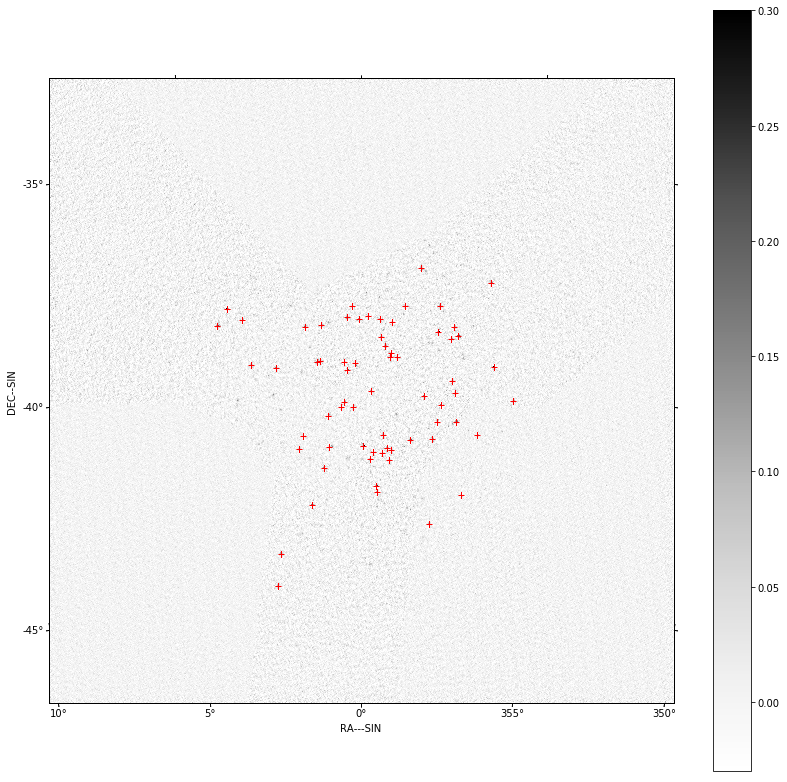

In [12]:
show_image(result[0], vmax=0.3, vmin=-0.03, components=recovered_mpccal_components)
export_image_to_fits(result[0], 'results/low-sims-mpc-restored_%dsources_rmax%.1f.fits' % (nsources, rmax))
plt.show()

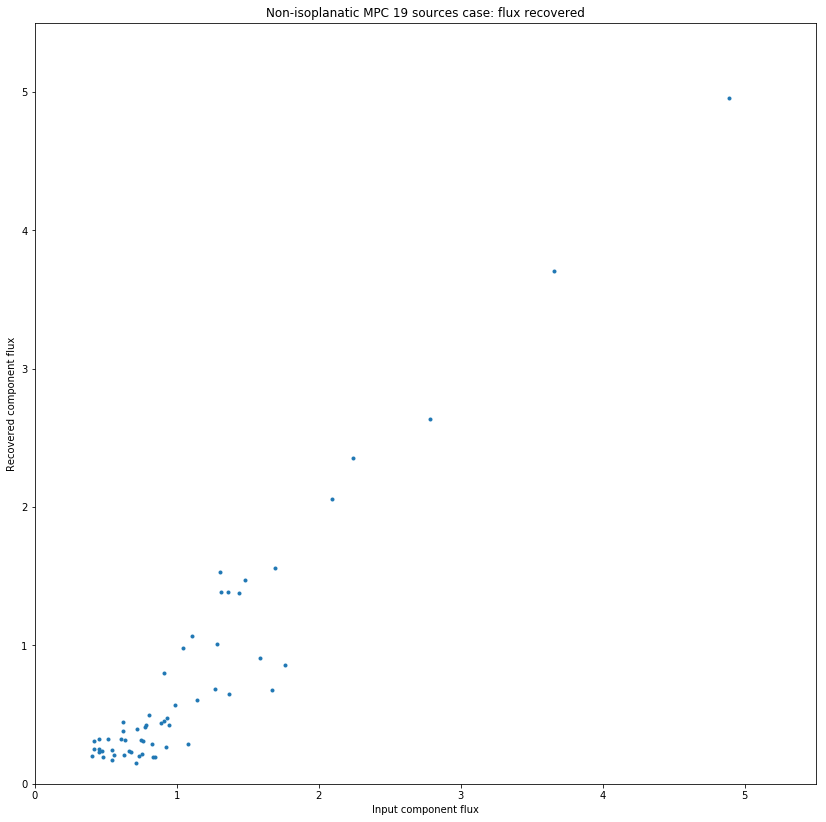

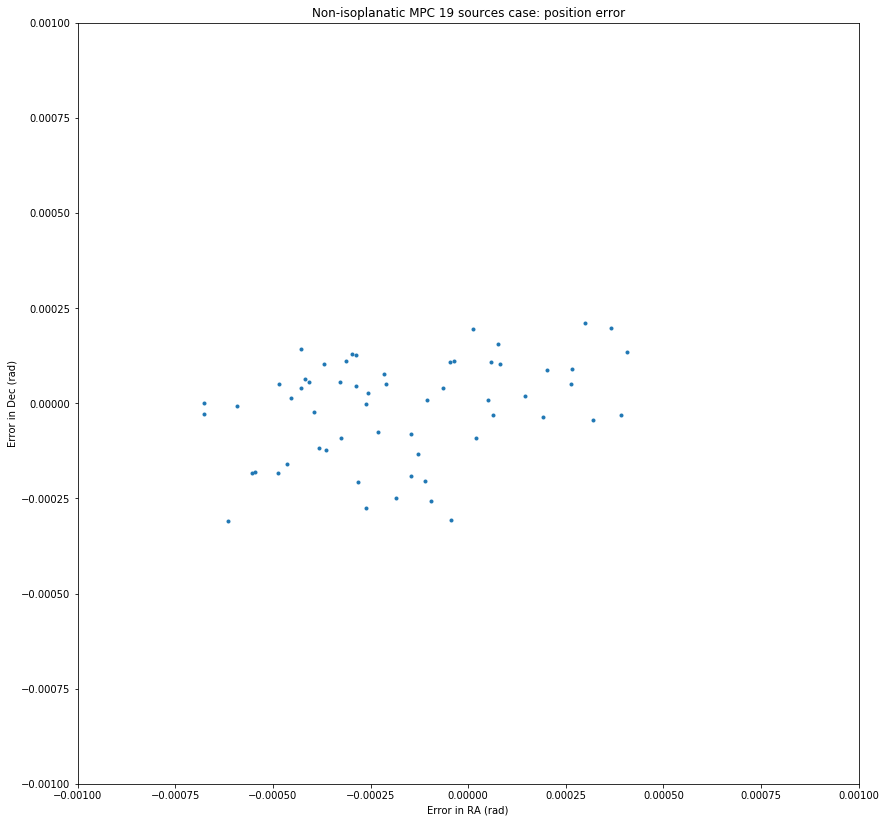

In [13]:
from data_models.data_model_helpers import import_skymodel_from_hdf5
gleam_skymodel_iso=import_skymodel_from_hdf5('results/low-sims-mpc-iso-skymodel_rmax%.1f.hdf5' % rmax)
from processing_components.skycomponent.operations import filter_skycomponents_by_flux
bright_gleam=filter_skycomponents_by_flux(gleam_skymodel_iso.components, flux_min=0.4)
def max_flux(elem):
    return numpy.max(elem.flux)
sorted_bright_gleam=sorted(bright_gleam, key=max_flux, reverse=True)

from wrappers.serial.skycomponent.operations import find_skycomponent_matches
matches = find_skycomponent_matches(recovered_mpccal_components, sorted_bright_gleam, tol=1e-3)
x=list()
y=list()
dx=list()
dy=list()
for match in matches:
    y.append(recovered_mpccal_components[match[0]].flux[0,0])
    x.append(sorted_bright_gleam[match[1]].flux[0,0])
    dx.append(recovered_mpccal_components[match[0]].direction.ra.rad-sorted_bright_gleam[match[1]].direction.ra.rad)
    dy.append(recovered_mpccal_components[match[0]].direction.dec.rad-sorted_bright_gleam[match[1]].direction.dec.rad)
        
plt.clf()
plt.plot(x, y, '.')
plt.xlim([0.0, 5.5])
plt.ylim([0.0, 5.5])
plt.xlabel('Input component flux')
plt.ylabel('Recovered component flux')
plt.title('Non-isoplanatic MPC %d sources case: flux recovered' % nsources)
plt.savefig('low-sims-mpc_mpccal_noniso_%dsources_flux_errors.jpg' % nsources)
plt.show()
    
plt.clf()
plt.plot(dx, dy, '.')
plt.xlim([-1e-3, 1e-3])
plt.ylim([-1e-3, 1e-3])
plt.xlabel('Error in RA (rad)')
plt.ylabel('Error in Dec (rad)')
plt.title('Non-isoplanatic MPC %d sources case: position error' % nsources)
plt.savefig('low-sims-mpc_mpccal_noniso_%dsources_position_errors.jpg' % nsources)
plt.show()
    

In [14]:
oldscreen=import_image_from_fits('screens/low_screen_5000.0r0_0.100rate.fits')
from processing_components.simulation.ionospheric_screen import grid_gaintable_to_screen
from processing_components.image.operations import create_empty_image_like
newscreen = create_empty_image_like(oldscreen)
gaintables = [th.gaintable for th in theta_list]
newscreen, weights = grid_gaintable_to_screen(blockvis, gaintables, newscreen)
print(qa_image(newscreen))
export_image_to_fits(newscreen, 'results/low-sims-mpc_mpccal-screen_%dsources_rmax%.1f.fits' % (nsources, rmax))
export_image_to_fits(weights, 'results/low-sims-mpc_mpccal-screenweights_%dsources_rmax%.1f.fits' % (nsources, rmax))

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 61, 2000, 2000)'
		max: '3.14113292512592'
		min: '-3.141028670931915'
		rms: '0.02309896167681973'
		sum: '-5735.829733773151'
		medianabs: '0.0'
		median: '0.0'



In [15]:
arlexecute.close()

arlexcute.close: closing down Dask Client


tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/timcornwell/anaconda3/envs/arl/lib/python3.6/site-packages/tornado/gen.py", line 936, in error_callback
    future.result()
concurrent.futures._base.CancelledError


In [16]:
export_image_to_fits(result[0], 'results/low-sims-mpc-restored_%dsources_rmax%.1f.fits' % (nsources, rmax))